# Entdecken von Malaria in Zellen

Autor: J. Kohl in 09/2020, Updates in 10/2021, 04/2023 und 11/23.

Teile dieses Notebooks sind entnommen aus:
* https://opensource.com/article/19/4/detecting-malaria-deep-learning
* [Keras-Dokumentation](https://www.tensorflow.org/guide/keras/sequential_model://)
* [Tensorflow-Dokumentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols)
* https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c
* https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/


## Problem statement

Klassifikation ob eine Zelle mit Malaria infiziert wurde oder nicht.
Zusätzlich Vergleich zwischen der Genauigkeit eines selbst gebauten CNN-Netzes sowie bekannter Transfer Learning Ansätze.

## Daten organisieren

Wir laden uns zuerst die Malaria-Bilder aus einem Verzeichnis auf unseren Google Colab-Account hoch.
Dabei wird ein Verzeichnis /cell-images/ angelegt mit folgender Unterstruktur:
* Parasitized: infizierte Zellen
* Uninfected: gesunde Zellen

In [ ]:
#!wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
!wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
!unzip cell_images.zip

Streaming output truncated to the last 5000 lines.
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_

In [ ]:
# Standardlibraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import os
import glob

INFECTED_DIR = '/content/cell_images/Parasitized'
HEALTHY_DIR = '/content/cell_images/Uninfected'

infected_files = glob.glob(INFECTED_DIR + '/*.png')
healthy_files  = glob.glob(HEALTHY_DIR + '/*.png')

print(len(infected_files), "Dateien mit Bildern infizierter Zellen")
print(len(healthy_files), "Dateien mit Bildern gesunder Zellen")

13779 Dateien mit Bildern infizierter Zellen
13779 Dateien mit Bildern gesunder Zellen


## Data Exploration

Wir öffnen aus beiden Verzeichnissen zufällige Dateien und schauen diese uns an. Zusätzlich interessiert uns auch die Struktur der Bilder, da wir ja nach Mustern suchen

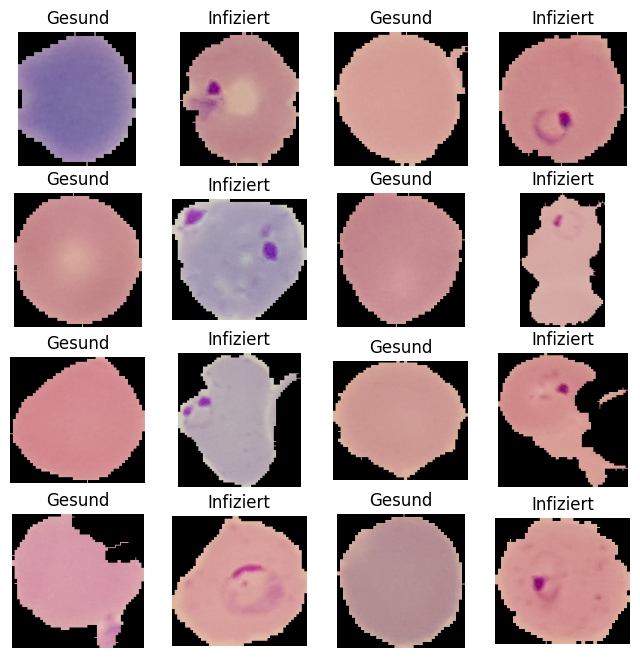

In [ ]:
import numpy as np
%matplotlib inline

number_cols = 4
number_rows = 4
run_index = 0

plt.figure(1 , figsize = (8 , 8))

for i in range(number_cols * number_rows):
  run_index += 1
  cur_plot = plt.subplot(number_cols, number_rows, run_index)

  if run_index % 2 == 0:
    plt.title('Infiziert')
    img = plt.imread(np.random.choice(infected_files)) # wähle ein zufälliges Bild aus der Menge der Bilder mit infizierten Zellen
  else:
    plt.title('Gesund')
    img = plt.imread(np.random.choice(healthy_files)) # wähle ein zufälliges Bild aus der Menge der Bilder mit gesunden Zellen

  plt.imshow(img)
  cur_plot.axis('Off') # Keine Achsen zeigen

plt.show()

Wenn man sich nur die zufällig ausgesuchten Bilder anschaut, könnte man vermuten, daß die rötlich gefärbten Kreise Malaria anzeigen.

Da man nie wissen kann, an welcher Stelle in der Zelle die so sind, muß man Algorithmen einsetzen, die Strukturen in den Bildern erkennen statt anhand einzelner, fixer Bildpunkte.

Genau das machen die Faltungsoperatoren in einem CNN.

## Data management

Wir haben jetzt 2 Möglichkeiten das Training vorzubereiten:
* Methode 1: wir nehmen die Daten direkt und teilen auf. Das Label kennen wir ja anhand Verzeichnisnamen
* Methode 2: wir nutzen das sogenannte **Data Augmentation**-Verfahren, das  die Bibliotheks-Funktionen von KERAS, unserer hier eingesetzten Machine Learning Library anbietet.

Die Idee von Data Augmentation ist, verschiedenste Operationen wie Drehen, Farben ändern, verzerren, etc. auf die Trainingsbilder anzuwenden. Dies ermöglicht zum Einen, mehr Trainingsbilder zu generieren für ein besseres Lernen (so können wir auch Machine Learning auf wenige Bilder starten).
Zum Anderen aber macht Data Augmentation unser Modell deutlich robuster, weil es durch die vielen leichten Veränderungen das Modell dazu zwingt, diese Veränderungen als mögliche Varianz zu lernen und so mehr zu generalisieren.

Methode 2 empfiehlt sich eigentlich immer, vor allem wenn wir unsere Modelle auch in der Praxis einsetzen wollen.

Der einzige Nachteil (neben längerer Trainingsphase ist), daß wir eine spezifische Verzeichnisstruktur brauchen.

Die Verzeichnisstruktur ist dabei immer gleich: es gibt je einen Ordner für Trainings-, Validierungs- und Testdaten. In jedem dieser Ordner ist dann eine Unterordnerstruktur, die die Anzahl und Namen der Zielklassen abbildet und die jeweiligen passenden Bilder enthält..
In unserem Fall Infiziert oder gesund gibt es somit in den Ordnern Train, Val und Test jeweils 2 Unterordner "Infiziert" und "gesund".

Wir müssen also die gesamte Anzahl Bilder für infizierte und gesunde Zellen gemäß der Klasse aufteilen und dann erneut in das bekannte Verhältnis Train zu Val zu Test.

Dies erledigt die Bibliotheksfunktion Splitfolders praktischerweise für uns

In [ ]:
!pip install split-folders tqdm
import splitfolders

input_folder = '/content/cell_images'
splitfolders.ratio(input_folder, output="output", seed=1337, ratio=(.6, .2, .2), group_prefix=None)

Copying files: 27560 files [00:04, 6043.77 files/s]


In dieser Zeile schauen wir uns genauer Data Augmentation an: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Sie können mit den Parametern gerne experimentieren. Wichtig ist aber, daß Sie die Normalisierung per rescale drinnen haben (rescale=1./255) und zwar bei Train, Test und Validation Generator!

Stellen Sie sich das so vor, wie wenn Sie verschiedenste Audio-Dateien in unterschiedlicher Lautstärke haben und manche Lieder zu laut und andere dafür zu leise sind. Wenn Sie eine einheitliche Lautstärke haben, brauchen Sie nicht regelmäßig die Lautstärke manuell anpassen.

Weiterhin wichtig ist daß Sie für die Validierungs- und Testmenge nur die Bilder normalisieren und shuffeln (damit nicht immer die gleichen Bilder zum Testen genommen werden). Sonst KEINE Augmentation, da Sie ja sonst die realen Bilder verzerren.

Ein weiterer Punkt: schauen Sie bei der Textausgabe dieser Zelle wie viele Bilder je Generator gefunden wurden. Die Zahl sollte schon deutlich, deutlich über 1000 liegen.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_image_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_image_gen.flow_from_directory(
    "/content/output/train",
    target_size=(150, 150),  # Alle Bilder haben Einheitsgröße 150 x 150
    color_mode = 'rgb',
    batch_size=256,
    class_mode='binary',
    shuffle=True)

validation_generator = test_image_gen.flow_from_directory(
    "/content/output/val",
    target_size=(150, 150),
    batch_size=256,
    color_mode = 'rgb',
    class_mode='binary',
    shuffle=True)

test_generator = test_image_gen.flow_from_directory(
     "/content/output/test",
     target_size=(150, 150),
     batch_size=256,
     color_mode = 'rgb',
     class_mode='binary',
     shuffle=True)

Found 16534 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


Wir schauen uns jetzt genauer die Klassen im Train_generator an. Diese brauchen wir nachher für die Klassifikation im Abschnitt Modell anwenden

In [ ]:
print(train_generator.class_indices)

{'Parasitized': 0, 'Uninfected': 1}


Wir sehen, daß parasitäre Bilder der Klasse 0, die gesunden der Klasse 1 zugeteilt werden. Das ist eine binäre Unterscheidung, die wir in eine Variable speichern können.

In [ ]:
num_classes = 1 # parasitized = infected = 0; healthy = uninfected = 1

Was machen diese Data Augmentations eigentlich mit einem Bild?

(([], []), ([], []))

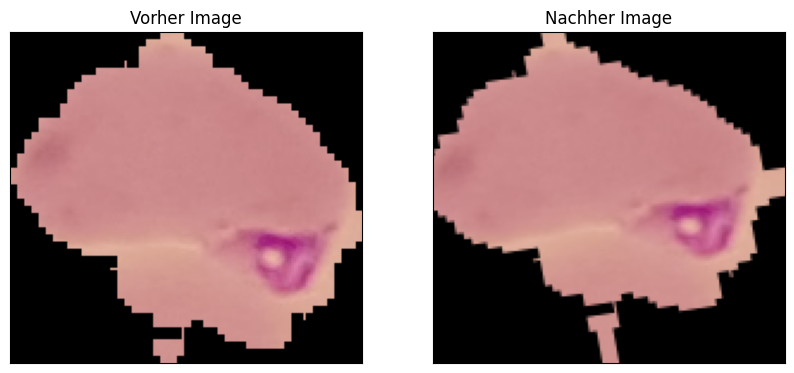

In [ ]:
example_infected_cell = np.random.choice(infected_files)

plt.figure(1, figsize = (10 , 7))

# Originalbild
plt.subplot(1 , 2 , 1)   # das sagt in Zeile 1 2 Bilder und jetzt wird das erste geplottet
img = plt.imread(example_infected_cell)
plt.imshow(img)
plt.title('Vorher Image')
plt.xticks([]) , plt.yticks([])

# Bild nachher
plt.subplot(1 , 2 , 2) # das sagt in Zeile 1 2 Bilder und jetzt wird das zweite geplottet
modified_img = plt.imread(example_infected_cell)
plt.imshow(train_image_gen.random_transform(modified_img))
plt.title('Nachher Image')
plt.xticks([]) , plt.yticks([])

## Simples Convolutional Neural Network

In [ ]:
import tensorflow as tf

INPUT_SHAPE = (150, 150, 3) # Größe Eingabebild: 150 Pixel Breite, 150 Pixel Höhe, 3 Farbkanäle (RGB)

inp = tf.keras.layers.Input(shape=INPUT_SHAPE) # Input Layer muß immer gleich der Struktur der Bilder sein!!!

# erster Faltoperator. Probieren Sie doch mal Änderungen des Filter (erste Zahl) und des Kernels aus!
conv1 = tf.keras.layers.Conv2D(32,
                               kernel_size=(3, 3),
                               activation='relu',
                               padding='same')(inp)

# Einsatz pooling um die bildgröße zu verkleinern und Bild auf die wichtigeren Inhalte zu reduzieren
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

# Einsatz Dropout für Vermeiden Overfitting und somit bessere Genauigkeit Modell
drop1 = tf.keras.layers.Dropout(0.5) (pool1)

conv2 = tf.keras.layers.Conv2D(64,
                               kernel_size=(3, 3),
                               activation='relu',
                               padding='same') (drop1)

pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
drop2 = tf.keras.layers.Dropout(0.5) (pool2)

conv3 = tf.keras.layers.Conv2D(128,
                               kernel_size=(3, 3),
                               activation='relu',
                               padding='same')(drop2)

pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

# das Lernen der Bildeigenschaften ist nun abgeschlossen (Sie können aber gern probieren, weitere Layer hinzuzufügen).

# Jetzt werden die gelernten Eigenschaften/ Charakteristiken des Bildes in ein "normales" neuronales Netz gespeist, um eine Klassifikation zu lernen
flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop4 = tf.keras.layers.Dropout(rate=0.5)(hidden1)

hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop4)
drop5 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(num_classes, activation='sigmoid')(drop5)

In [ ]:
model = tf.keras.Model(inputs=inp, outputs=out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,590,593 (82.36 MB)

 Trainable params: 21,590,593 (82.36 MB)

 Non-trainable params: 0 (0.00 B)

Hier definieren wir die folgenden Hyperparameter:
* **Batch_size**: wie viele Samples werden aus der Trainingsmenge genommen bevor die Gewichte und Bias des Modells angepaßt werden. Im unteren Fall heißt das, nach 32 Bildern passen wir die Gewichte an. Je höher der Wert, desto weniger Anpassungen; je geringer der Wert, desto mehr Anpassungen. Das hat dann Auswirkungen auf wie schnell das Trainieren konvergiert....32 ist eine gute Faustregel.
* **Epochen**: wie viele Durchläufe durch das gesamte Datenset gemacht werden. Je mehr Epochen, desto länger dauert das Testen. Die Genauigkeit nimmt aber - bis zu einem gewissen Punkt - mit der Anzahl der Epochen zu; ab einem gewissen Punkt stagniert die Genauigkeit aber, das Modell **overfittet**. Um das zu vermeiden, setzen wir ein Abbruchkriterium ein (**earlystopping**, siehe unten).
* **Learning_rate**: Geschwindigkeit mit der das Modell lernt. Genauer gesagt stellt es die Schrittweite dar, die bei jeder Iteration gegangen wird, um das Minimum der Loss-Funktion zu erreichen.
* **Optimizer**: Algorithmus der eingesetzt wird, um die Gewichte und Bias so zu reduzieren, daß die Loss-Funktion minimiert wird.

Diese Parameter ermöglichen deutliche Verbesserungen des Ergebnisses und  stehen auch miteinander in Verbindung (bspw. small batch size sollte mit niedriger Lernrate kombiniert werden).

Zusätzlich wenden wir 2 Callbacks ein, um uns beim Trainieren zu helfen. Der eine Callback ist frühzeitiges Abbrechen des Trainierens, wenn wir nach mehreren Durchläufen nicht besser werden, um Zeit zu sparen; der andere Callback ist daß immer das Modell mit der höchsten Genauigkeit gespeichert wird.


Nachdem wir das gemacht haben, starten wir das Trainieren des Models.

In [ ]:
BATCH_SIZE = 32 # ACHTUNG: ab und zu gibt es von Colab Fehlermeldungen mit out of memory. Falls diese kommen, dann bitte die Batch-Size anpassen
EPOCHS = 10 # Je mehr Epochen, desto länger dauert das Testen. Mit wenigen Epochen ist die Genauigkeit recht schlecht.

opt = tf.keras.optimizers.Adam( learning_rate=0.001)

model.compile(loss='binary_crossentropy', # das wird genommen bei 2 Zielklassen
              optimizer=opt,
              metrics=['accuracy'])

# Modell Callback 1: überwache die Validation accuracy. Falls diese nicht nach 3 Durchläufen besser wird, brich das Training ab.
mcp_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=3,
    verbose=1)

# Modell Callback 2: speichere immer das beste Modell in das Verzeichnis /content/best_models/vanilla_cnn
mcp_save_best = tf.keras.callbacks.ModelCheckpoint(
    '/content/best_models/vanilla_cnn/vanilla.weights.h5',
    save_best_only=True,
    monitor='val_accuracy',
    save_weights_only=True,
    mode='max')

history_vanilla_CNN = model.fit(
    train_generator,  # lade die Daten/ Bilder aus dem Train_Generator
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    #steps_per_epoch = len(train_generator.filenames) // (BATCH_SIZE),  # wenn wir den Parameter per Kommentar auskommentieren, wird standardmäßig was berechnet
    validation_data=validation_generator,  # lade die Validation Data aus dem Validation Generator
    #validation_steps=len(validation_generator.filenames) // (BATCH_SIZE)
    callbacks=[mcp_save_best, mcp_early_stopping] # verwende beide definierten Prüfunge
    )

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.5418 - loss: 0.6868 - val_accuracy: 0.7712 - val_loss: 0.5140
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8543 - loss: 0.4090 - val_accuracy: 0.9396 - val_loss: 0.1947
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9291 - loss: 0.2167 - val_accuracy: 0.9521 - val_loss: 0.1665
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9413 - loss: 0.1873 - val_accuracy: 0.9537 - val_loss: 0.1540
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9472 - loss: 0.1665 - val_accuracy: 0.9545 - val_loss: 0.1534
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9484 - loss: 0.1689 - val_accuracy: 0.9577 - val_loss: 0.1444
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9511 - loss: 0.1616 - val_accuracy: 0.9539 - val_loss: 0.1457
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9497 - loss: 0.1561 - val_accuracy: 0.9568 - v

In [ ]:
# wir laden jetzt das beste Modell während des Trainings.
model.load_weights('/content/best_models/vanilla_cnn/vanilla.weights.h5')

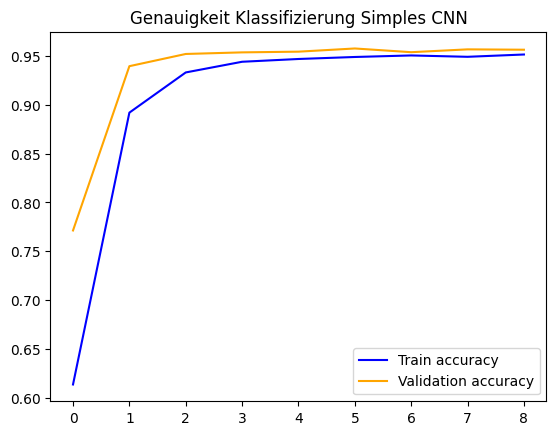

In [ ]:
# Plotte Genauigkeit
plt.title('Genauigkeit Klassifizierung Simples CNN')
plt.plot(history_vanilla_CNN.history['accuracy'], color='blue', label='Train accuracy')
plt.plot(history_vanilla_CNN.history['val_accuracy'], color='orange', label='Validation accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('/content/best_models/basic_malaria_model.h5')

## Transfer Learning

Die Genauigkeit von Deep Learning Verfahren hängt von der Größe und der Datenqualität der Trainingsmenge ab sowie von der - oft durch Ausprobieren- verwendeten Struktur des CNN-Netzes.

An dieser Stelle ermöglicht Transfer Learning deutliche Zeitersparnis und Effizienzgewinne durch das Verwenden eines schon auf Millionen von Daten vortrainierten Modells.

Die Idee von Transfer Learning ist genauer gesagt, alle Elemente des vortrainierten Modells bis auf die letzten 1-2 Schichten direkt zu übernehmen und dann die letzten beiden Schichten (meist aber nur die letzte Schicht) auf das vorliegende Problem anzupassen und dann das modifizierte Modell auf die Traningsmenge erneut zu trainieren.

Es gibt viele vortrainierte Modelle, Keras bietet folgende an:




Allgemeine Erklärung der Spalten:
* Top1- und Top5-Genauigkeit bezieht sich auf die Performance des Modells beim  ImageNet validation dataset. Bei diesem Datensatz gibt das Modell bis zu 5 Vorhersagen. Top 1 sagt wie häufig die Vorhersage des Modells mit dem höchsten Wert stimmte. Top 5 sagt, wie häufig in den Top 5 Vorhersagen das richtige enthalten war.
* Parameters: je mehr Parameter, desto mehr Zeit zum Lernen wird benötigt.
* Tiefe: wie viele Schichten das Modell hat. Je mehr, desto mehr Zeit wird zum Lernen und für die Inferenz benötigt.

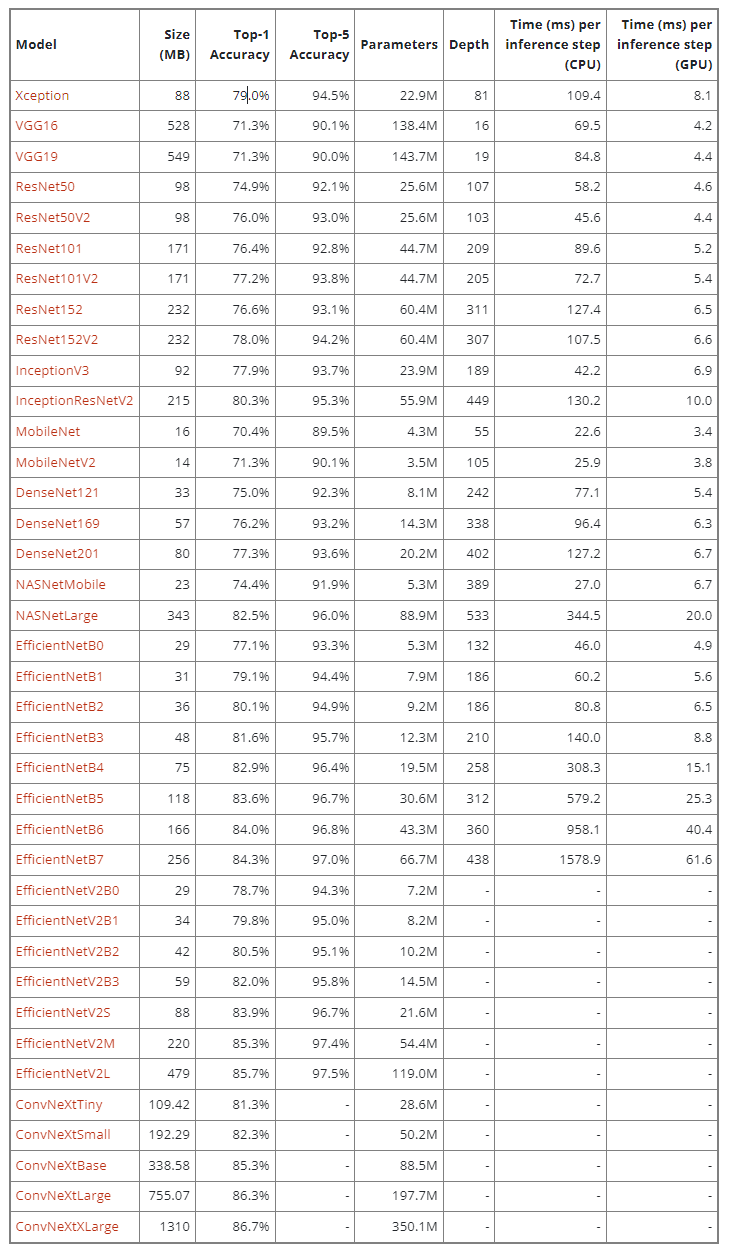

Wir setzen für den weiteren Verlauf das [VGG16](https://arxiv.org/pdf/1409.1556) sowie das neuere [EfficientNet]https://arxiv.org/pdf/1905.11946.pdf) ein. VGG benötigt als Input-Format für Bilder 224x224x3 weshalb wir die Bilder per ImageDataGen anpassen.

Das Einsetzen von anderen Transfer Learning-Modellen geschieht analog.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_gen_VGG = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_image_gen_VGG = ImageDataGenerator(rescale=1./255)

train_generator_VGG = train_image_gen_VGG.flow_from_directory(
    "/content/output/train",
    target_size=(224, 224),
    color_mode = 'rgb',
    batch_size=32,
    class_mode='binary',
    shuffle=True)

validation_generator_VGG = test_image_gen_VGG.flow_from_directory(
    "/content/output/val",
    target_size=(224, 224),
    batch_size=32,
    color_mode = 'rgb',
    class_mode='binary',
    shuffle=True)

Found 16534 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


### VGG16

VGG16 ([Detailinfos](https://arxiv.org/abs/1409.1556)) hat folgende Struktur:

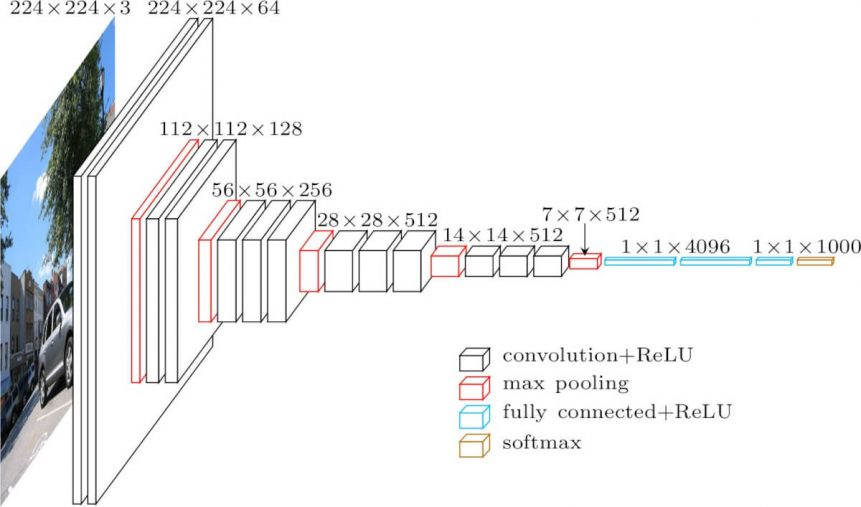

Schaut man sich die ganze Struktur als Sequenzdiagram an, sieht sie wie folgt aus:

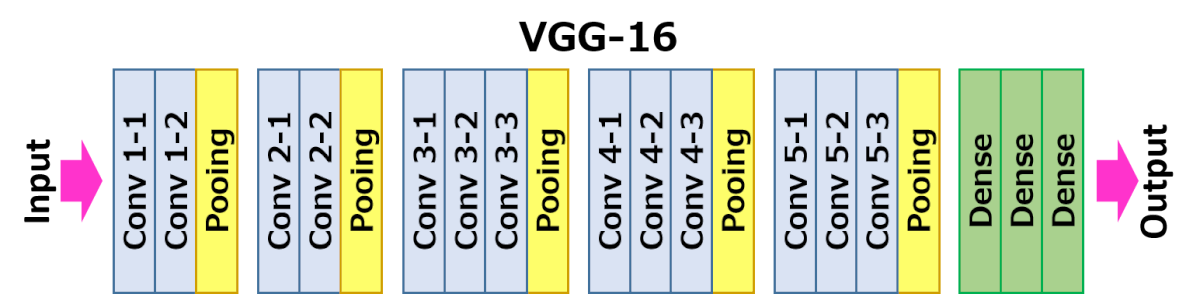 Quelle: [Link](https://neurohive.io/en/popular-networks/vgg16/)

Die Idee vom Transfer Learning ist nun, daß wir die Bilderkennung in den ersten Schichten übernehmen, aber an die bestehenden Schichten des Klassifikators (grüne Farbe) einen eigenen Klassifikator ersetzen. Alternativ kann man auch die grünen Schichten ersetzen durch einen eigenen Klassifikator.

Weiterhin sorgen wir dafür, daß bei der Backpropagation nur die Schichten unseres Klassifikators angepaßt werden und **nicht** die Schichten für die Bilderkennung.

In [ ]:
import tensorflow as tf

vgg_new = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3))

base_vgg_new = vgg_new
base_out_new = base_vgg_new.output  # speichern des letzten Layers des VGG16 in base_out_new. Hier kommen die neuen Layer dran

# ab hier hängen wir weitere Schichten an das Modell an. Das Ziel ist dabei das Modell auf unseren Anwendungsfall anzupassen
flatten = tf.keras.layers.Flatten()(base_out_new)
out = tf.keras.layers.Dense(num_classes, activation='sigmoid')(flatten)  # wir haben ja nur 2 Klassen (infiziert/ gesund)

# koppeln altes modell mit gerade definierten Schichten
VGG_model_new = tf.keras.Model(inputs=base_vgg_new.input, outputs=out)

# ACHTUNG: bei VGG bitte SGD als Optimizer nehmen, Adam braucht viel länger für Optimierung!
VGG_model_new.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# explizit setzen aller Schichten auf nicht trainierbar.
for layer in VGG_model_new.layers:
  layer.trainable = False

# aber der letzte, neu hinzugefügte Layer, ist trainierbar. Sonst hätte das ganze ja nichts gebracht
for layer in VGG_model_new.layers[-1:]:
  layer.trainable = True

print("Total Layers:", len(VGG_model_new.layers))
print("Total trainable layers:", sum([1 for l in VGG_model_new.layers if l.trainable]))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Total Layers: 24
Total trainable layers: 1


In [ ]:
VGG_model_new.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,049,473 (76.48 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Man sieht die neue Struktur. Die Layer sind bis auf die letzten 2 Zeilen der Tabelle vom VGG16, die letzten beiden - Flatten 1 und dense_3 - sind neu hinzugekommen. Diese trainieren wir jetzt, damit das gesamte Netz auf Erkennen von Malaria-Zellen angepaßt wird.
Wir trainieren also die 25089 Parameter aus der letzten Zeile auf Malaria.

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10  #

# Modell Callback 1: überwache die Validation accuracy. Falls diese nicht nach 3 Durchläufen besser wird, brich das Training ab.
mcp_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)

# Modell Callback 2: speichere immer das beste Modell in das Verzeichnis /content/best_models/VGG
mcp_save_best = tf.keras.callbacks.ModelCheckpoint('/content/best_models/VGG/VGG.weights.h5',
                                                   save_best_only=True,
                                                   monitor='val_accuracy',
                                                   save_weights_only=True,
                                                   mode='max')

historyVGG = VGG_model_new.fit(
    train_generator_VGG,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator_VGG,
    callbacks=[mcp_save_best, mcp_early_stopping] # verwende beide definierten Prüfungen
    )

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 292s 538ms/step - accuracy: 0.5565 - loss: 0.6858 - val_accuracy: 0.6123 - val_loss: 0.6633
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 265s 513ms/step - accuracy: 0.6424 - loss: 0.6506 - val_accuracy: 0.6912 - val_loss: 0.6339
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 266s 514ms/step - accuracy: 0.6928 - loss: 0.6280 - val_accuracy: 0.7221 - val_loss: 0.6142
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 264s 510ms/step - accuracy: 0.7013 - loss: 0.6146 - val_accuracy: 0.7364 - val_loss: 0.5968
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 265s 512ms/step - accuracy: 0.7251 - loss: 0.5956 - val_accuracy: 0.7582 - val_loss: 0.5846
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 264s 510ms/step - accuracy: 0.7380 - loss: 0.5818 - val_accuracy: 0.7409 - val_loss: 0.5717
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 266s 515ms/step - accuracy: 0.7466 - loss: 0.5687 - val_accuracy: 0.7518 - val_loss: 0.5608
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 269s 520ms/step - accuracy: 0.7529 -

In [ ]:
# wir laden jetzt das beste Modell während des Trainings.
VGG_model_new.load_weights('/content/best_models/VGG/VGG.weights.h5')

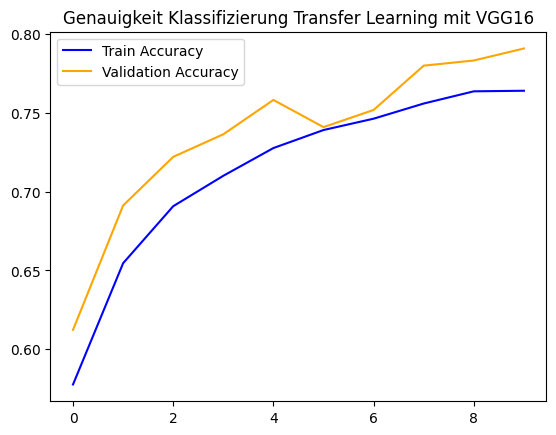

In [ ]:
# Plotte Genauigkeit
plt.title('Genauigkeit Klassifizierung Transfer Learning mit VGG16')
plt.plot(historyVGG.history['accuracy'], color='blue', label='Train Accuracy')
plt.plot(historyVGG.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
VGG_model_new.save('/content/best_models/vgg_augmented_data.h5')

### Efficient Net

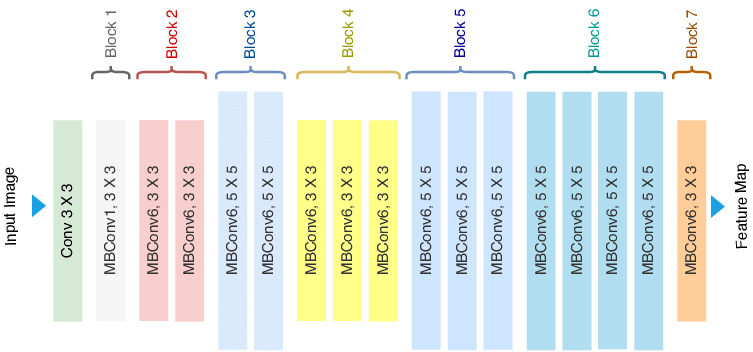

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_gen_EfficientNet = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #rescale=1./255, # EfficientNet models in Keras have the rescaling logic built inside the model architecture.
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_image_gen_EfficientNet = ImageDataGenerator()

train_generator_EfficientNet = train_image_gen_EfficientNet.flow_from_directory(
    "/content/output/train",
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=True)

validation_generator_EfficientNet = test_image_gen_EfficientNet.flow_from_directory(
    "/content/output/val",
    target_size=(224, 224),
    batch_size=64,
    color_mode = 'rgb',
    class_mode='binary',
    shuffle=True)

Found 16534 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [ ]:
baseModelEfficientNet = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    classifier_activation="softmax",
    input_shape=(224, 224, 3)
)

baseModelEfficientNet.trainable = False

# wir fügen 1 layer hinzu um unsere eigene Klassifikation zu machen
base_out = baseModelEfficientNet.output
x = tf.keras.layers.GlobalAveragePooling2D()(base_out)  # Average2dPooling instead of flatten
x = tf.keras.layers.Dropout(0.2)(x) # Recommended for EfficientNet
out = tf.keras.layers.Dense(1, activation='sigmoid')(x) # num_classes = 1

EfficientNet = tf.keras.Model(inputs=baseModelEfficientNet.input, outputs=out)


print("Total Layers:", len(EfficientNet.layers))
print("Total trainable layers:", sum([1 for l in EfficientNet.layers if l.trainable]))

# explizit setzen aller Schichten auf nicht trainierbar.
for layer in EfficientNet.layers:
  layer.trainable = False

# aber der letzte, neu hinzugefügte Layer, ist trainierbar. Sonst hätte das ganze ja nichts gebracht
for layer in EfficientNet.layers[-1:]:
  layer.trainable = True

EfficientNet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Higher rate for the new head
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Total Layers:", len(EfficientNet.layers))
print("Total trainable layers:", sum([1 for l in EfficientNet.layers if l.trainable]))

Total Layers: 241
Total trainable layers: 3
Total Layers: 241
Total trainable layers: 1


In [ ]:
EfficientNet.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_20        │ (None, 224, 224,  │          0 │ input_layer_13[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_10    │ (None, 224, 224,  │          7 │ rescaling_20[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_21        │ (None, 224, 224,  │          0 │ normalization_10… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_21[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64 # hier größere Batchsize um Training zu beschleunigen

# Modell Callback 1: überwache die Validation accuracy. Falls diese nicht nach 3 Durchläufen besser wird, brich das Training ab.
mcp_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    verbose=1
)

# Modell Callback 2: speichere immer das beste Modell in das Verzeichnis /content/best_models/EfficientNet
mcp_save_best = tf.keras.callbacks.ModelCheckpoint(
    '/content/best_models/EfficientNet/EffNet.weights.h5',
    save_best_only=True,
    monitor='val_accuracy',
    save_weights_only=True,
    mode='max'
)

historyEfficientNet = EfficientNet.fit(
    train_generator_EfficientNet,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator_EfficientNet,
    callbacks=[mcp_early_stopping, mcp_save_best]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 257s 912ms/step - accuracy: 0.8029 - loss: 0.4329 - val_accuracy: 0.8826 - val_loss: 0.2702
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 216s 834ms/step - accuracy: 0.9121 - loss: 0.2360 - val_accuracy: 0.9017 - val_loss: 0.2399
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 217s 837ms/step - accuracy: 0.9154 - loss: 0.2265 - val_accuracy: 0.9165 - val_loss: 0.2129
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 214s 827ms/step - accuracy: 0.9192 - loss: 0.2188 - val_accuracy: 0.9155 - val_loss: 0.2108
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 215s 831ms/step - accuracy: 0.9254 - loss: 0.2019 - val_accuracy: 0.9167 - val_loss: 0.2106
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 213s 822ms/step - accuracy: 0.9282 - loss: 0.1985 - val_accuracy: 0.9245 - val_loss: 0.1965
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 214s 827ms/step - accuracy: 0.9246 - loss: 0.2049 - val_accuracy: 0.9193 - val_loss: 0.2037
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 213s 821ms/step - accuracy: 0.9283 -

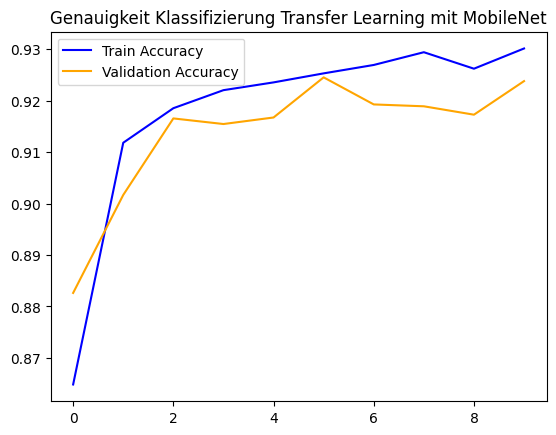

In [ ]:
# Plotte Genauigkeit
plt.title('Genauigkeit Klassifizierung Transfer Learning mit MobileNet')
plt.plot(historyEfficientNet.history['accuracy'], color='blue', label='Train Accuracy')
plt.plot(historyEfficientNet.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
EfficientNet.save('/content/best_models/EfficientNet_augmented_data.h5')

## Modellgüte testen

In [ ]:
basic_cnn = tf.keras.models.load_model('/content/best_models/basic_malaria_model.h5')
vgg_augmented = tf.keras.models.load_model('/content/best_models/vgg_augmented_data.h5')
efficient_net_augmented = tf.keras.models.load_model('/content/best_models/EfficientNet_augmented_data.h5')

Hier testen wir die einzelnen Modelle inkl. Testgenerators.

In [ ]:
loss_Basic_CNN, accuracy_Basic_CNN = basic_cnn.evaluate(test_generator)
print('Test accuracy :', accuracy_Basic_CNN)

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9513 - loss: 0.1564
Test accuracy : 0.9530116319656372


In [ ]:
test_generator_VGG = test_image_gen_VGG.flow_from_directory(
     "/content/output/test",
     target_size=(224, 224),
     batch_size=32,
     color_mode = 'rgb',
     class_mode='binary',
     shuffle=True)

loss_VGG, accuracy_VGG = vgg_augmented.evaluate(test_generator_VGG)
print('Test accuracy :', accuracy_VGG)

Found 5512 images belonging to 2 classes.
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - accuracy: 0.7774 - loss: 0.5385
Test accuracy : 0.782837450504303


In [ ]:
# mobileNet
test_generator_efficient_net = test_image_gen_EfficientNet.flow_from_directory(
     "/content/output/test",
     target_size=(224, 224),
     batch_size=32,
     color_mode = 'rgb',
     class_mode='binary',
     shuffle=True)

loss_EfficientNet, accuracy_EfficientNet = EfficientNet.evaluate(test_generator_efficient_net)
print('Test accuracy :', accuracy_EfficientNet)

Found 5512 images belonging to 2 classes.
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9178 - loss: 0.2052
Test accuracy : 0.9218069911003113


## Modell anwenden

Wie funktioniert ein Einsatz des Modells nachher?
Bei einem "realen" Einsatz würde das Modell in der Cloud oder Handy gespeichert bzw. "deployed" werden.

Das Modell erhält dann ein/ mehrere Bilder als Input und berechnet eine prozentuale Zahl, die ausdrückt, zu welcher der Zielklassen das Bild gehört.
Da wir nur 2 Zielklassen haben, ist der Schwellwert für die Zuordnung bei 50%.

### Vorhersage mehrerer Bilder

Hier Code für mehrere Bilder mit Einsatz des einfachen CNN

In [ ]:
import matplotlib.image as mpimg

test_generator.reset()

cnn_pred_labels = model.predict(test_generator, 1000)

print("Predictions finished")
print(len(cnn_pred_labels))

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step
Predictions finished
5512


Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png
Parasitized/C130P91ThinF_IMG_20151004_142709_cell_126.png
Parasitized/C170P131ThinF_IMG_20151119_120111_cell_229.png
Parasitized/C184P145ThinF_IMG_20151203_104334_cell_17.png
Parasitized/C60P21thinF_IMG_20150804_105955_cell_133.png
Parasitized/C91P52ThinF_IMG_20150821_123116_cell_199.png
Uninfected/C117P78ThinF_IMG_20150930_215322_cell_75.png
Uninfected/C152P113ThinF_IMG_20151115_124323_cell_28.png
Uninfected/C188P149ThinF_IMG_20151203_134449_cell_85.png
Uninfected/C237ThinF_IMG_20151127_104748_cell_88.png
Uninfected/C64P25N_ThinF_IMG_20150818_153517_cell_49.png
Uninfected/C98P59ThinF_IMG_20150917_154235_cell_20.png


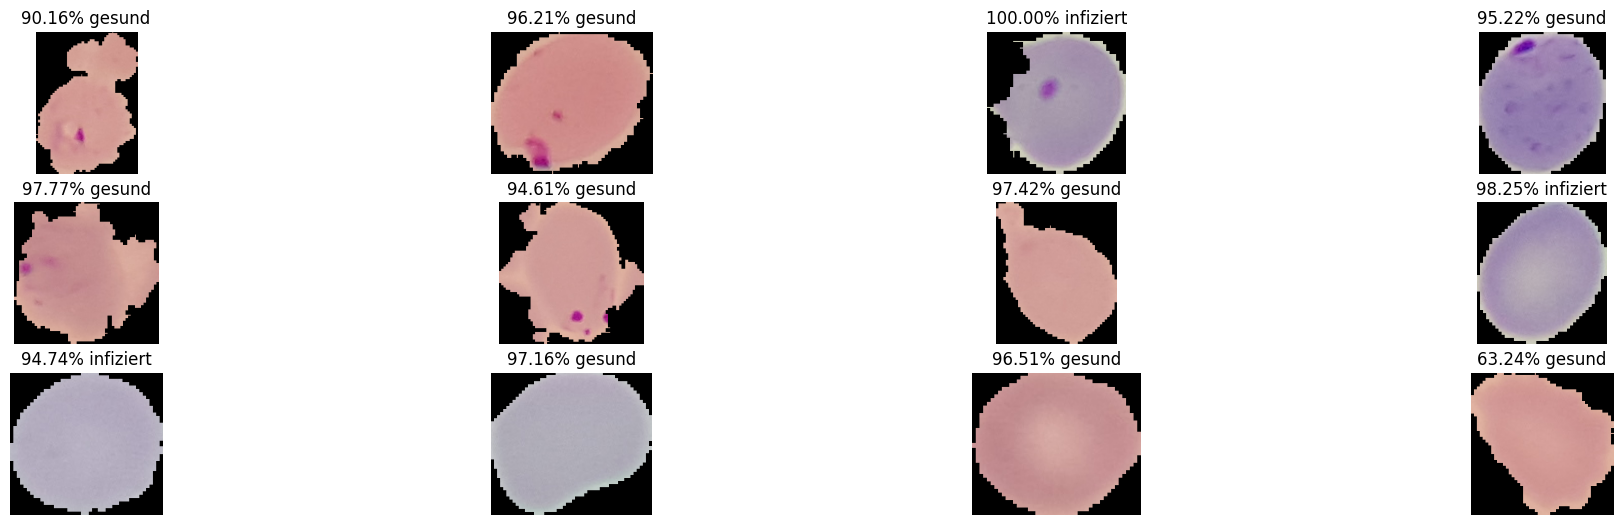

In [ ]:
# oder anderes Modell als Basis nehmen
number_cols = 4
number_rows = len(cnn_pred_labels) // 500
run_index = 0

plt.figure(1 , figsize = (24, 24))

for index, probability in enumerate(cnn_pred_labels):
    # nur jedes 500. Bild plotten, sonst zu viele Bilder
    if index % 500 == 0:
      run_index += 1
      cur_plot = plt.subplot(number_rows, number_cols, run_index)

      image_path = '/content/output/test/' + test_generator.filenames[index]
      img = mpimg.imread(image_path)

      plt.imshow(img)
      print(test_generator.filenames[index])
      if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% gesund")
      else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% infiziert")
    #plt.show()
    cur_plot.axis('Off') # Keine Achsen zeigen

plt.show()

### Vorhersage eines Bildes

Hier der Code für Vorhersage eines Bildes mit EfficientNet

In [ ]:
from keras.preprocessing import image

def classify_pic(imagePath):
  img = tf.keras.utils.load_img(imagePath, target_size=(224, 224))
  img_tensor = tf.keras.utils.img_to_array(img)                    # (Höhe, Breite, Kanäle = RGB)
  img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, Höhe, Breite, Kanäle), und eine dimension dazufügen. Erwartet wird folgende Struktur: (batch_size, height, width, channels)
  img_tensor /= 255.                                      # Bild normalisieren

  predictions_single = EfficientNet.predict(img_tensor)

  # aus einer vorherigen Zeile wissen wir, daß parasitäre Zellen den class_index 0 haben.
  if predictions_single <= 0.5:
    print("{} ist infiziert".format(imagePath))
  else:
    print("{} ist gesund".format(imagePath))

  print("mit Genauigkeit von {}%".format(probability[0]*100))

  plt.imshow(img)
  cur_plot.axis('Off') # Keine Achsen zeigen
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
/content/output/test/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png ist gesund
mit Genauigkeit von 97.53211975097656%


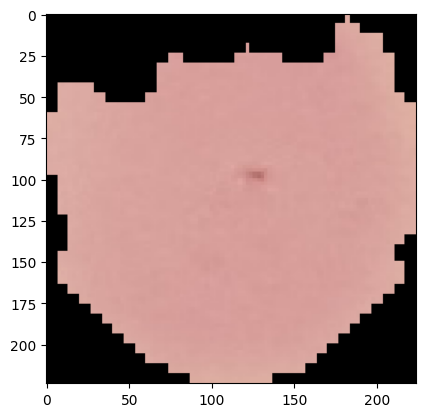

In [ ]:
classify_pic("/content/output/test/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png")

## Explainability

Explainability bezeichnet die Eigenschaft einess Machine Learning Modells, zu erklären, wieso es zu einer Ausgabe kam; oder in unserem Fall: wieso es eine Zelle als infiziert erkennt.

Diese Fähigkeit ist für Machine Learning Modelle sehr relevant in sicherheitsrelevanten Einsatzgebieten (bspw. autonomes Fahren: wieso hat das Fahrzeug gebremst? Oder gar nicht gebremst?) sowie bei Root Cause/ Diagnoseanalysen (bspw. was ist die Ursache für einen Fehler? Wieso diese Krankheit?).

Leider ist es aufgrund der Struktur von Neuronalen Netzen die Explainability eher schwer. Dies liegt nicht nur an den vielen, vielen möglichen Hidden Layers, sondern auch an der Verknüpfung der einzelnen Layer miteinander.

In diesem Abschnitt wollen wir uns deshalb über bildliche Analyse anschauen, wie ein Input-Bild durch die Schichten des Netzes durchgereicht wird und was jeweils in den Schichten erkannt wird.



### Explainability für CNN

Wir schauen uns die Explainability zuerst für das simple CNN an, da es deutlich weniger Layer hat als die Transfer Learning Modelle.

Der Code basiert dabei auf [Link](https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c).

Wir bauen im ersten Schritt ein Modell für die Visualisierung

In [ ]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

Jetzt passen wir ein Bild an das Format des "neuen" CNN an und jagen es durch das CNN

In [ ]:
img = tf.keras.utils.load_img("/content/output/test/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png", target_size=(150, 150))
img_tensor = tf.keras.utils.img_to_array(img)                    # (Höhe, Breite, Kanäle = RGB)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, Höhe, Breite, Kanäle), und eine dimension dazufügen. Erwartet wird folgende Struktur: (batch_size, height, width, channels)
img_tensor /= 255.                                      # Bild normalisieren

successive_feature_maps = visualization_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


/tmp/ipython-input-493893341.py:17: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
/tmp/ipython-input-493893341.py:20: RuntimeWarning: invalid value encountered in cast
  x  = np.clip(x, 0, 255).astype('uint8')


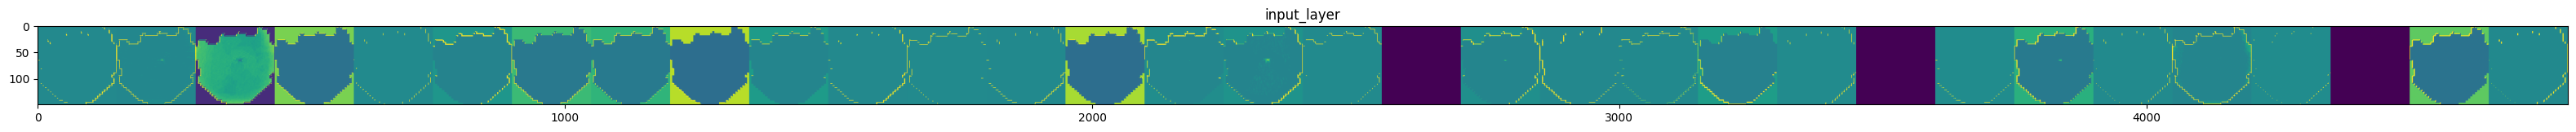

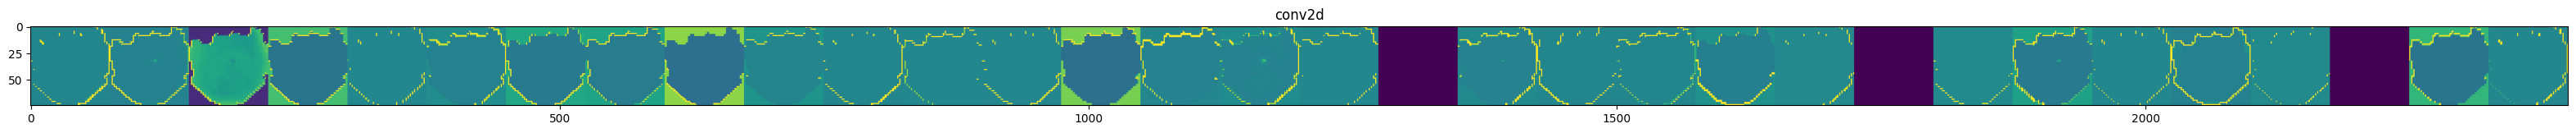

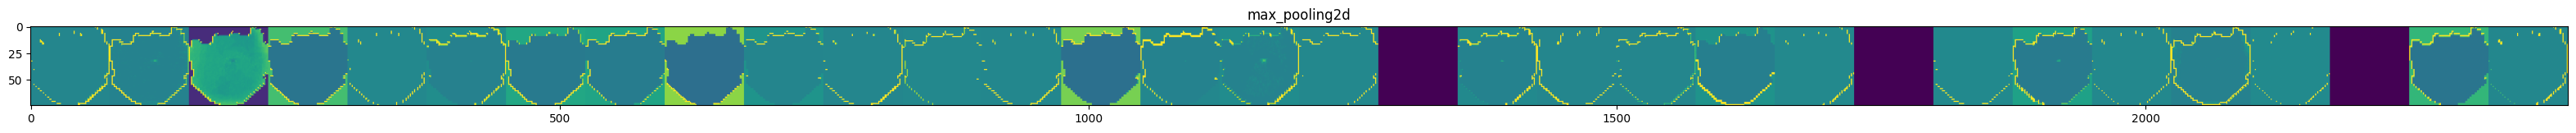

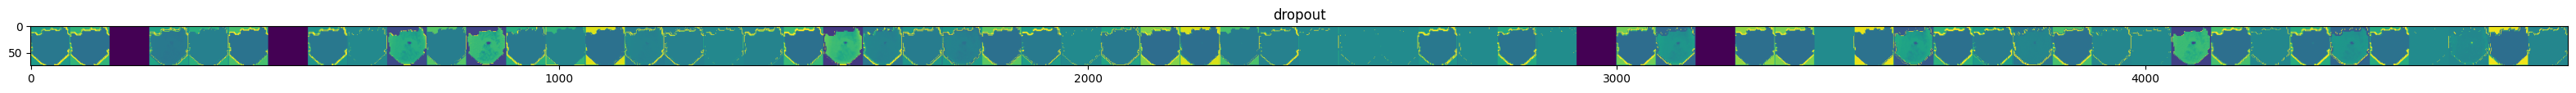

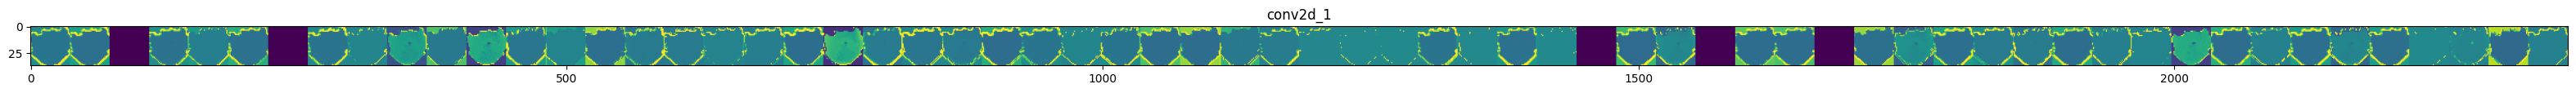

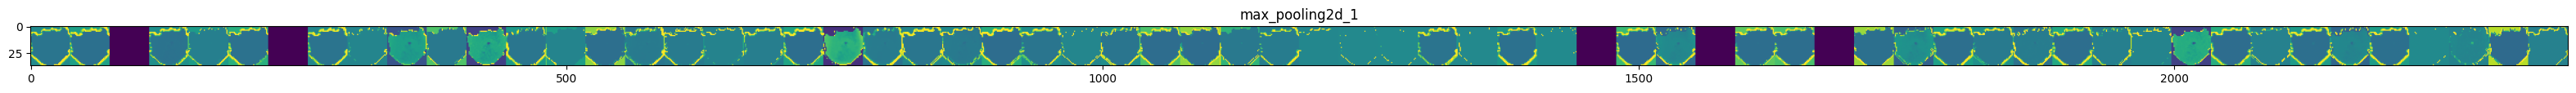

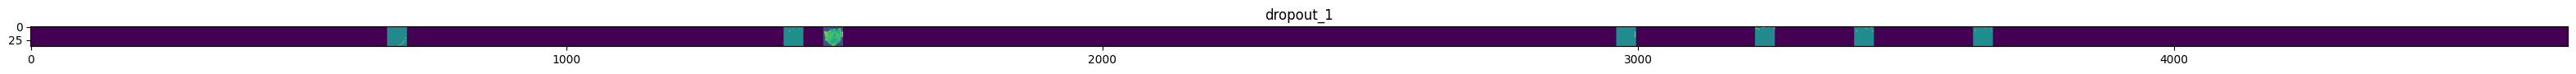

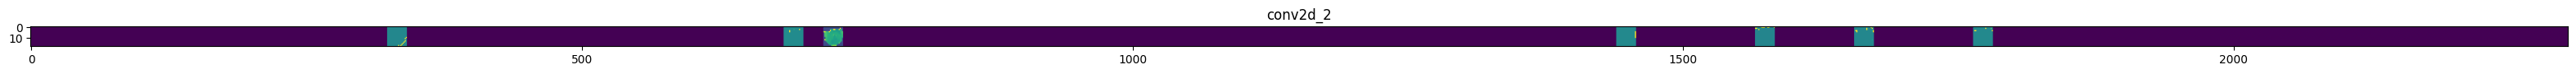

In [ ]:
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))

    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features * 2, scale * 2) )
    #plt.figure( figsize=(8, 8) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

### Explainability für VGG16

Schauen wir uns die Explainability am Beispiel von VGG16-Modell an, um die interessanten Abschnitte zu finden für eine Visualisierung.

Der Code ist entnommen aus [Link](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)

In [ ]:
from keras.models import Model

VGG_16_model = tf.keras.applications.vgg16.VGG16() # load the model

# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]

outputs = [VGG_16_model.layers[i].output for i in ixs]
VGG_16_model = Model(inputs=VGG_16_model.inputs, outputs=outputs)

# load the image with the required shape
img = tf.keras.utils.load_img("/content/output/test/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png", target_size=(224, 224))
img = tf.keras.utils.img_to_array(img) # convert the image to an array
img = np.expand_dims(img, axis=0) # expand dimensions so that it represents a single 'sample'
img = tf.keras.applications.vgg16.preprocess_input(img) # prepare the image (e.g. scale pixel values for the vgg)

# put image into model and get feature map for first hidden layer
feature_maps = VGG_16_model.predict(img)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


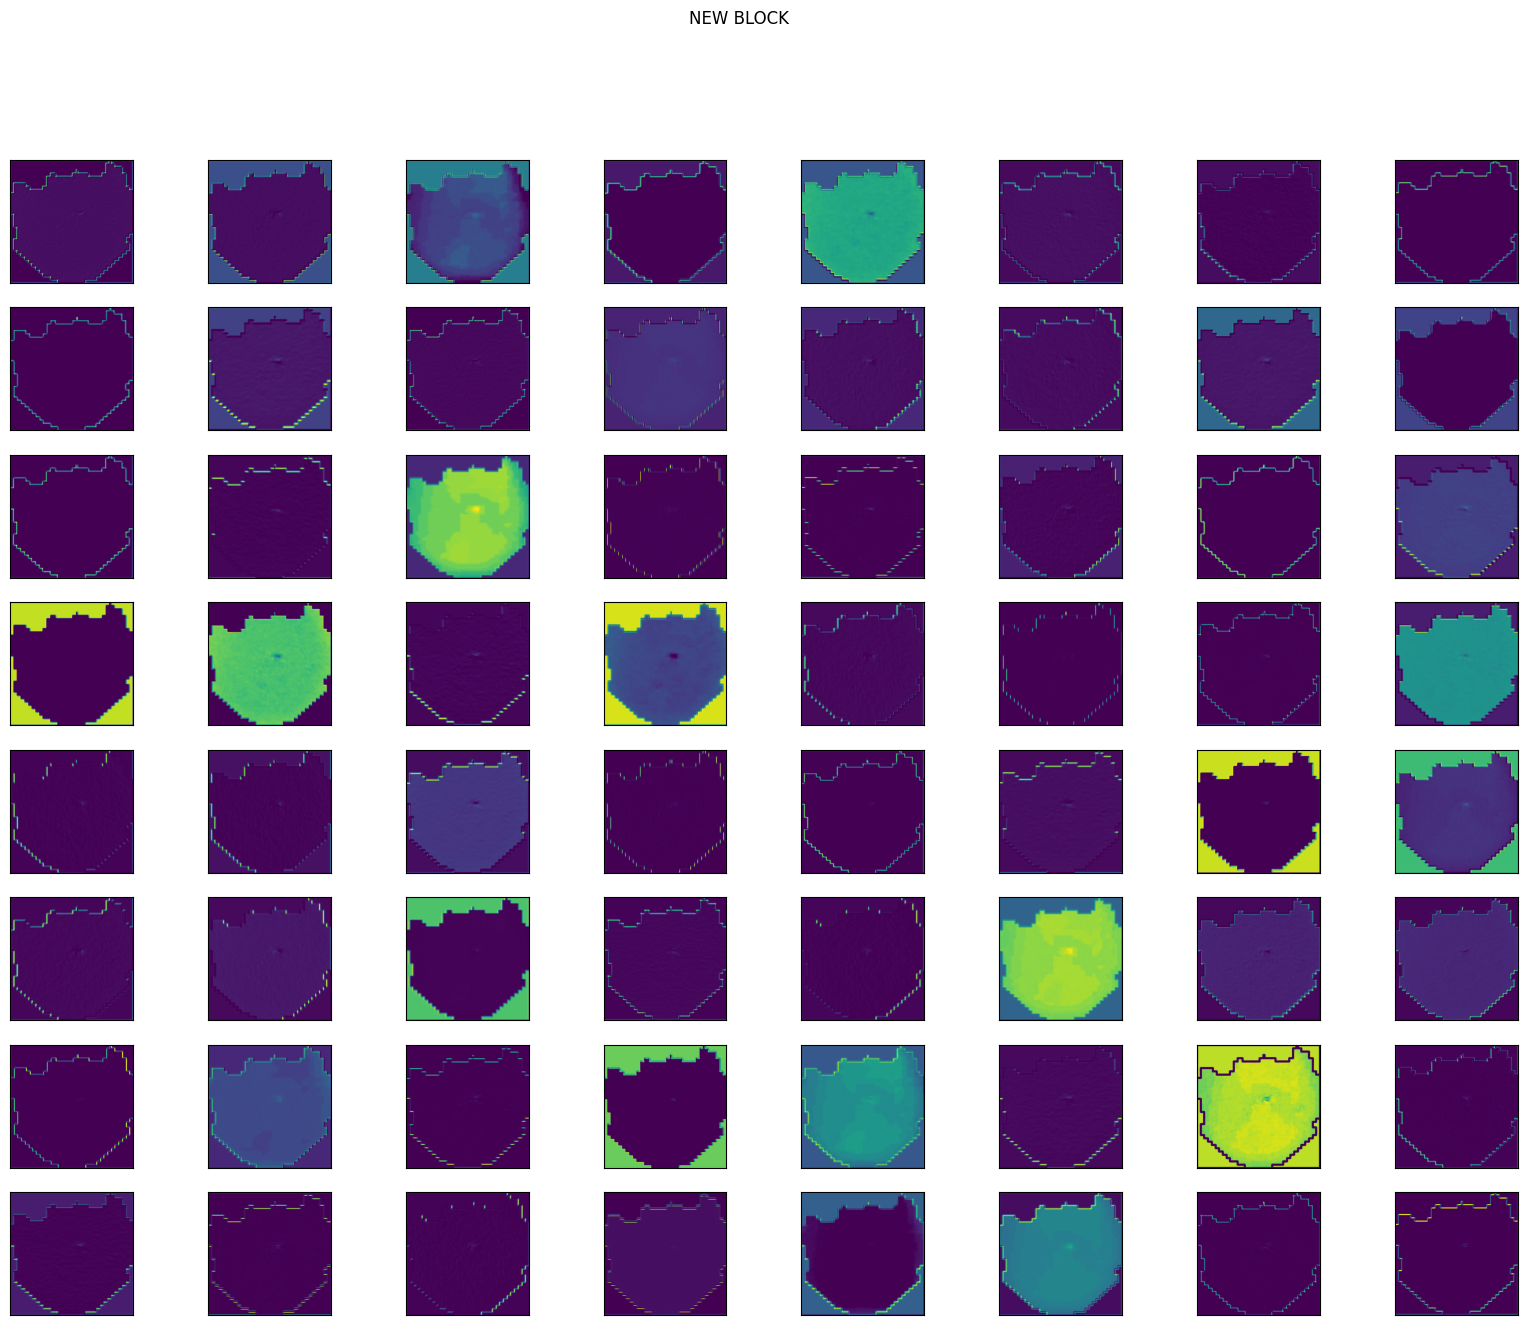

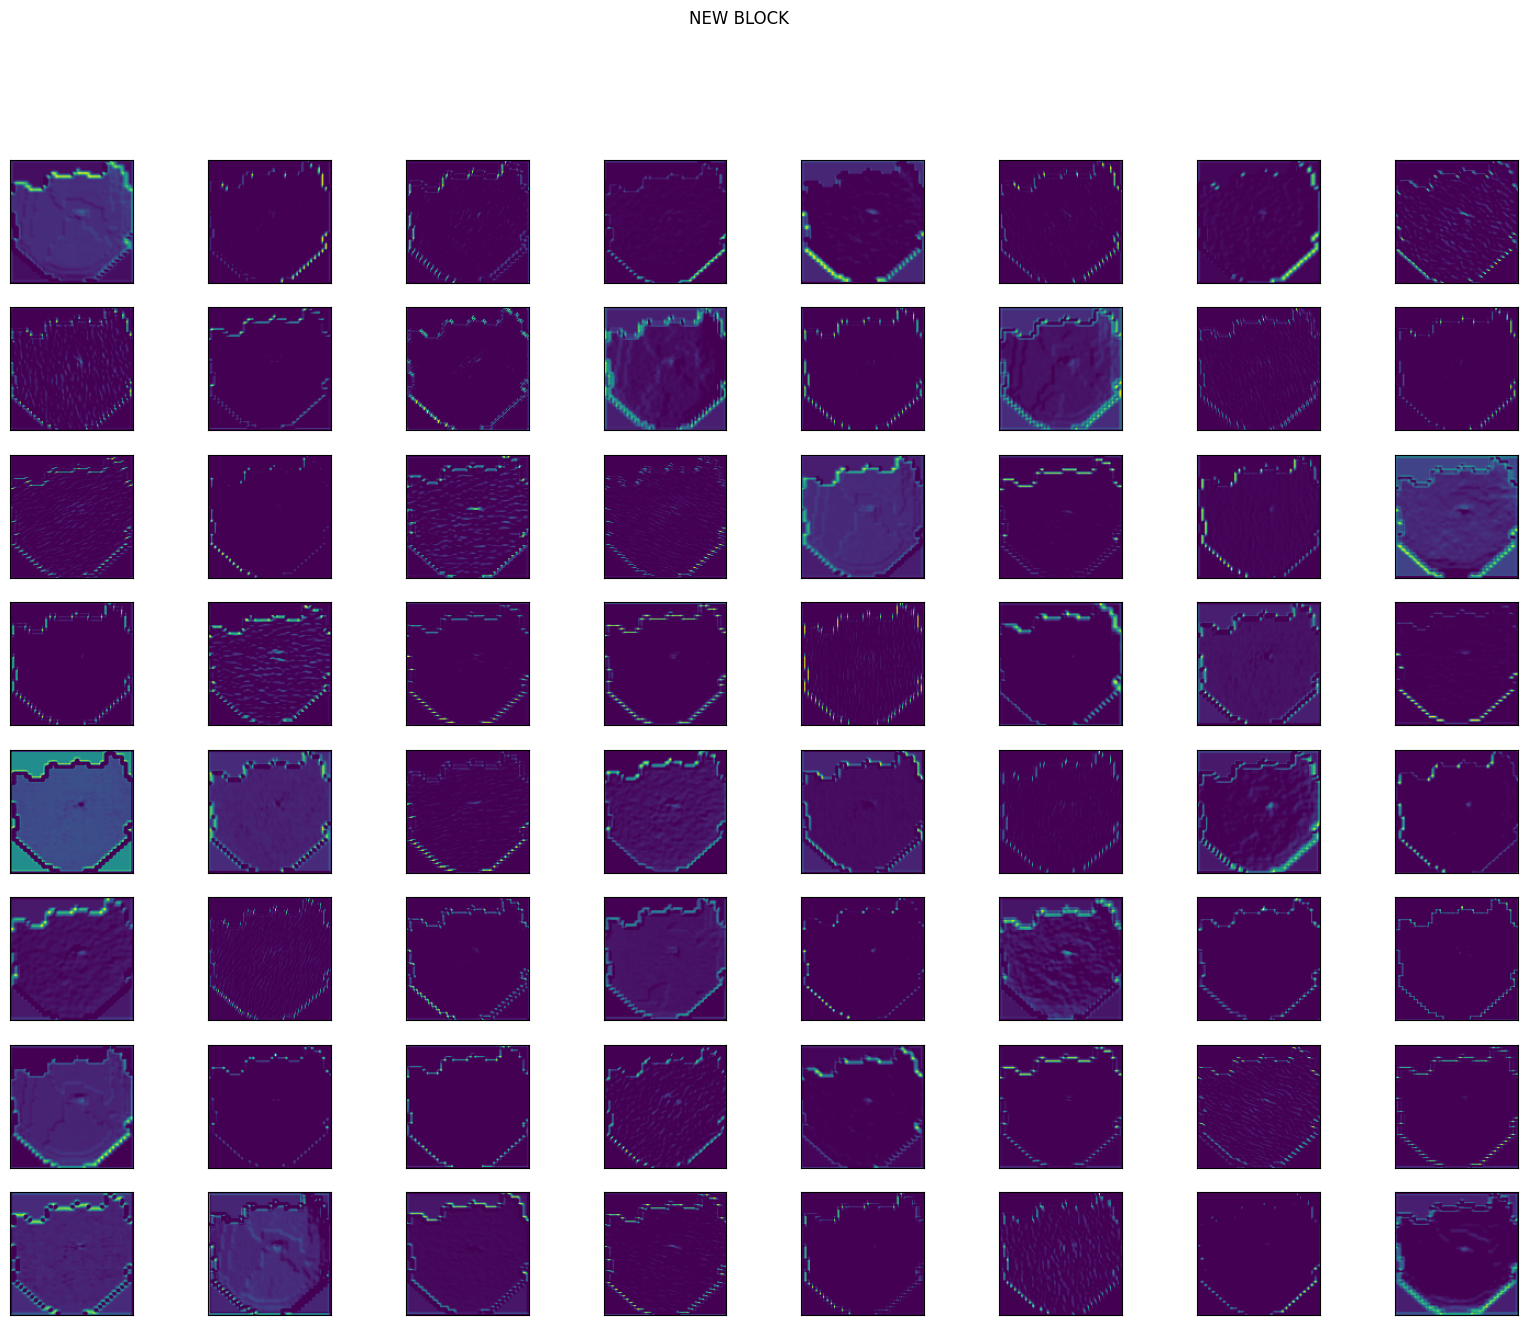

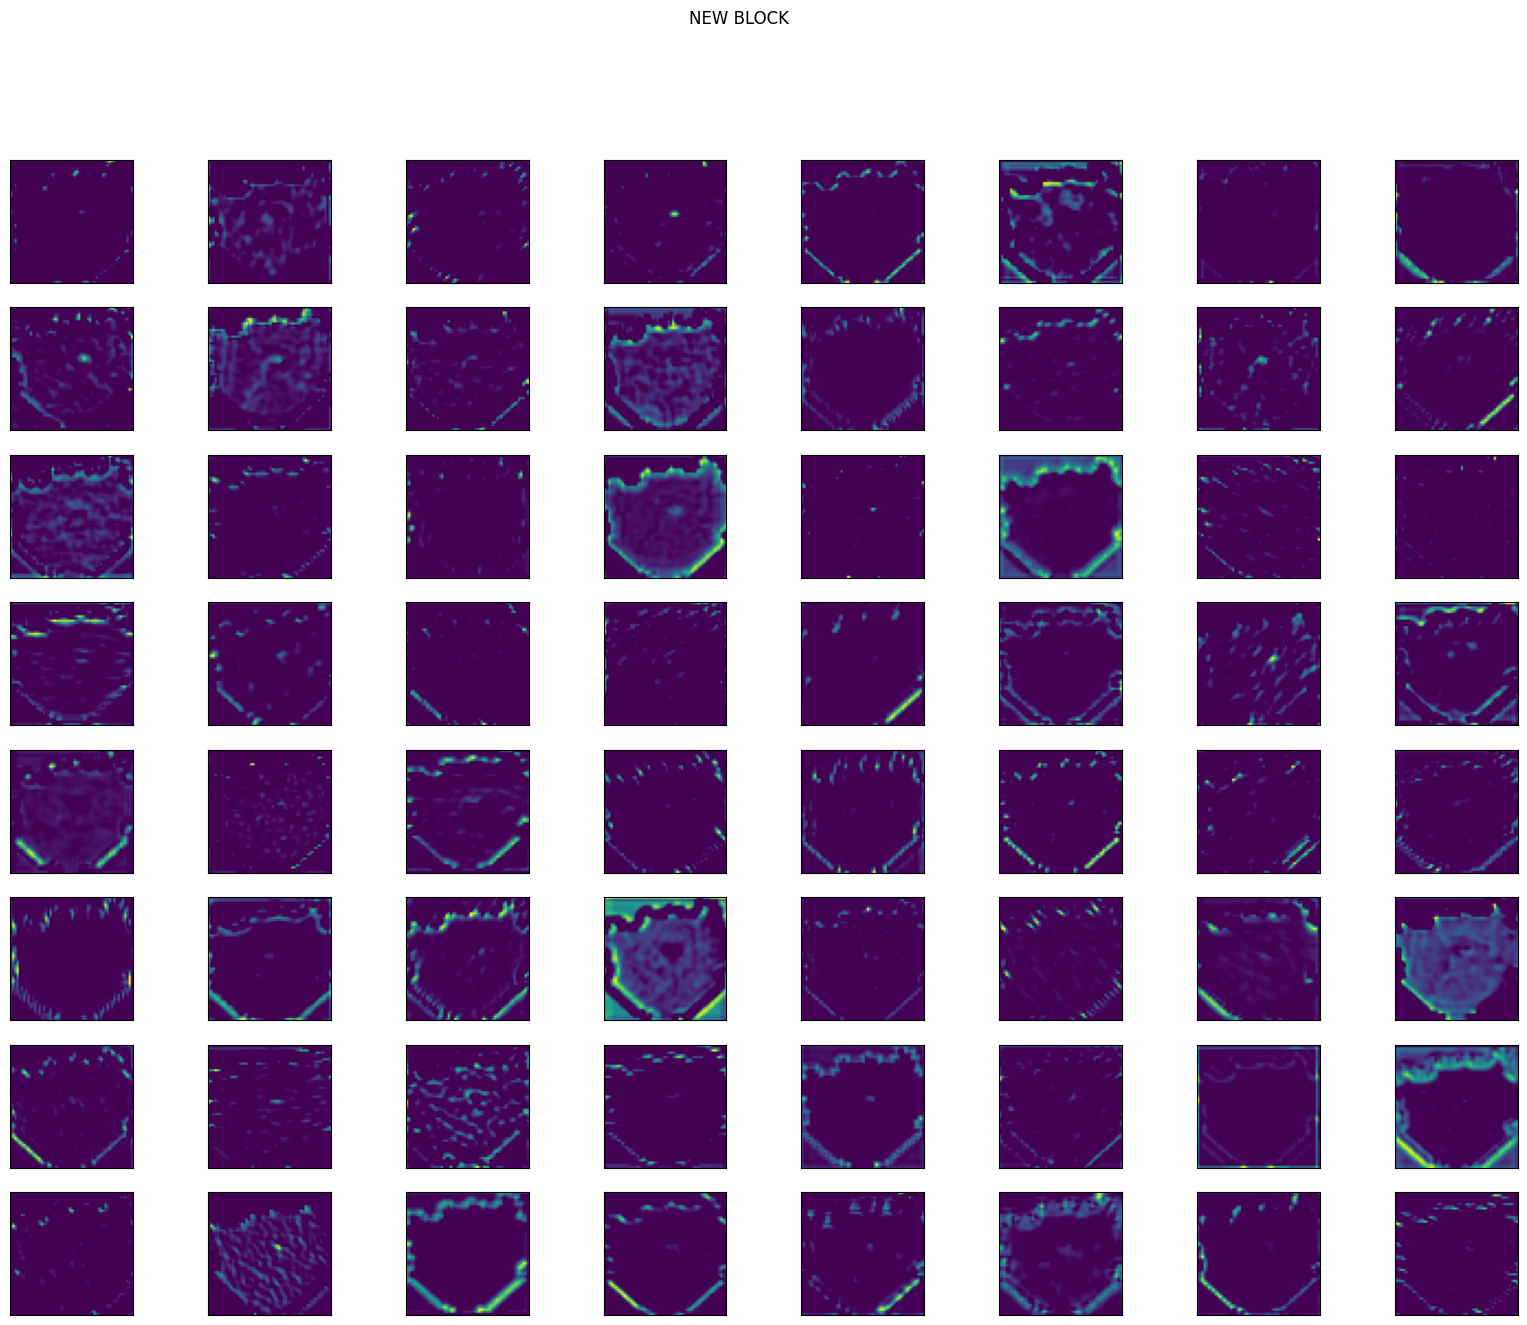

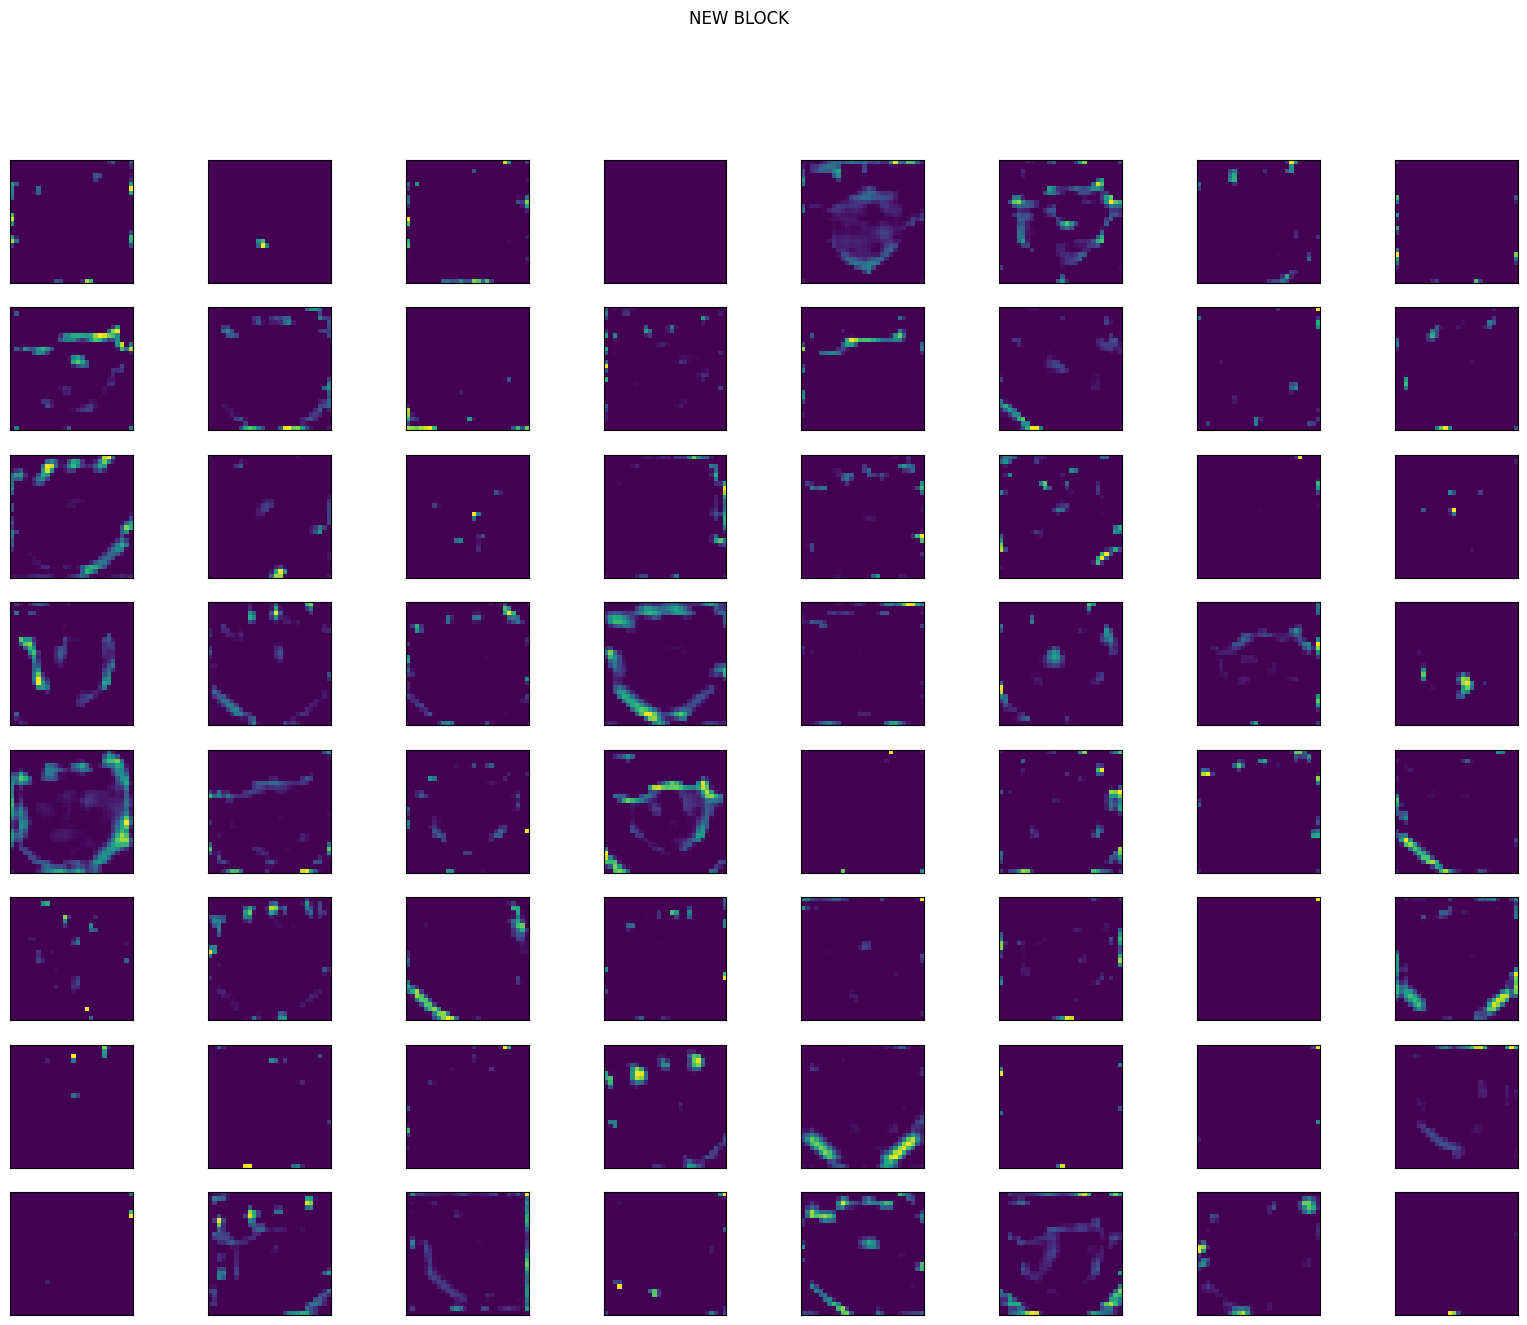

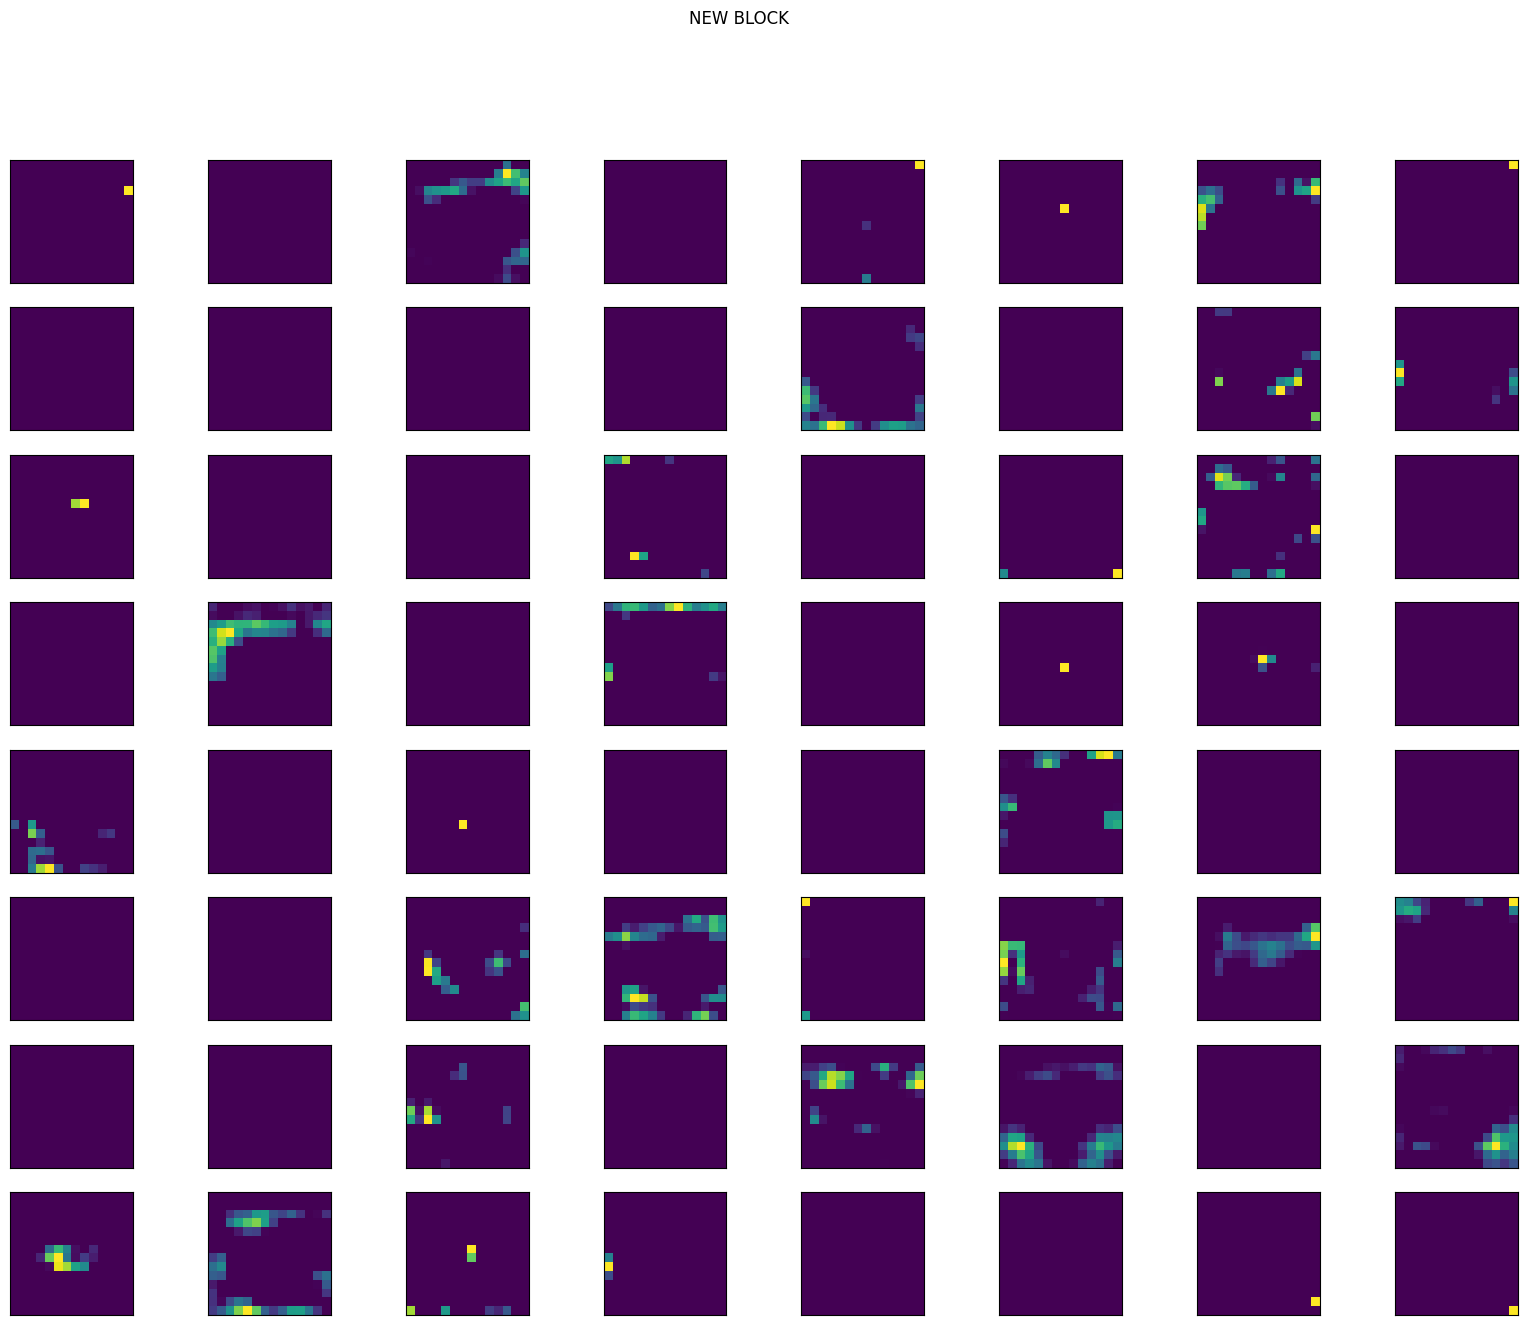

In [ ]:
# plot the output from each block in 8x8
square = 8
for fmap in feature_maps:
  # plot all 64 maps in an 8x8 squares
  ix = 1
  fig = plt.figure(figsize=(20,15))
  fig.suptitle("NEW BLOCK", fontsize=12)

  for _ in range(square):
    for _ in range(square):
      # specify subplot and turn of axis
      ax = plt.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
      ix += 1
  # show the figure
  plt.show()